# Classification 

### About Company
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.


### Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.
Create a Classification Model taking Loan_applied as the target column and considering rest of the columns as the feature. Understand the distribution of data in different columns, take the relevant features and train the model to predict the Loan_applied column


### Schema:
ID = Unique record ID
Gender = Male/ Female
Married = Applicant married (Y/N)
Dependents = Number of dependents
Education = Applicant Education (Graduate/ Under Graduate)
Self_Employed = Self employed (Y/N)
ApplicantIncome = Applicant income
CoapplicantIncome = Coapplicant income
Credit_History = Credit history meets guidelines(0- No, 1- Yes)
Property_Area = Urban/ Semi Urban/ Rural
Loan_Applied = Loan applied (Y/N)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


#### Dataset

In [2]:
data = "/kaggle/input/loan-data-set/loan_data_set.csv"

#### Load the Data

In [3]:
#data
df = pd.read_csv(data)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### Explore the dataset

In [4]:
print("dataset shape")
print(df.shape)

print(50*'=')
print("\n Dataset column Name")
print(df.columns)

print(50*'=')
print("Target column")
print(df['Loan_Status'].value_counts())

dataset shape
(614, 13)

 Dataset column Name
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Target column
Loan_Status
Y    422
N    192
Name: count, dtype: int64


#### Handle Missing Values

In [5]:
# missing values
print("Missing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

Missing Values:
Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64


In [6]:
df_new = df.copy()

# Gender: Filling with mode
df_new['Gender'].fillna(df_new['Gender'].mode()[0], inplace=True)

# Married: Filling with mode
df_new['Married'].fillna(df_new['Married'].mode()[0], inplace=True)

#Dependents: Filling with mode
df_new['Dependents'].fillna(df_new['Dependents'].mode()[0], inplace=True)

# Self_Employed: Filling with mode
df_new['Self_Employed'].fillna(df_new['Self_Employed'].mode()[0], inplace=True)

# LoanAmount: Filling with median - to have less impact of outliers
df_new['LoanAmount'].fillna(df_new['LoanAmount'].median(), inplace=True)

# Loan_Amount_Term: Fill with mode 
df_new['Loan_Amount_Term'].fillna(df_new['Loan_Amount_Term'].mode()[0], inplace=True)

# Credit_History: Fill with mode (most likely 1.0)
df_new['Credit_History'].fillna(df_new['Credit_History'].mode()[0], inplace=True)


print("\nMissing values after handling:")
print("="*50)
print(df_new.isnull().sum())




Missing values after handling:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


Text(0.5, 1.0, 'Loan Status Distribution')

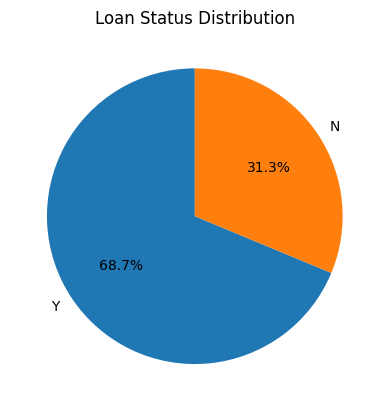

In [7]:
plt.pie(df_new['Loan_Status'].value_counts().values, 
              labels=df_new['Loan_Status'].value_counts().index,
              autopct='%1.1f%%', startangle=90)
plt.title('Loan Status Distribution')


Text(0.5, 0, 'Property Area')

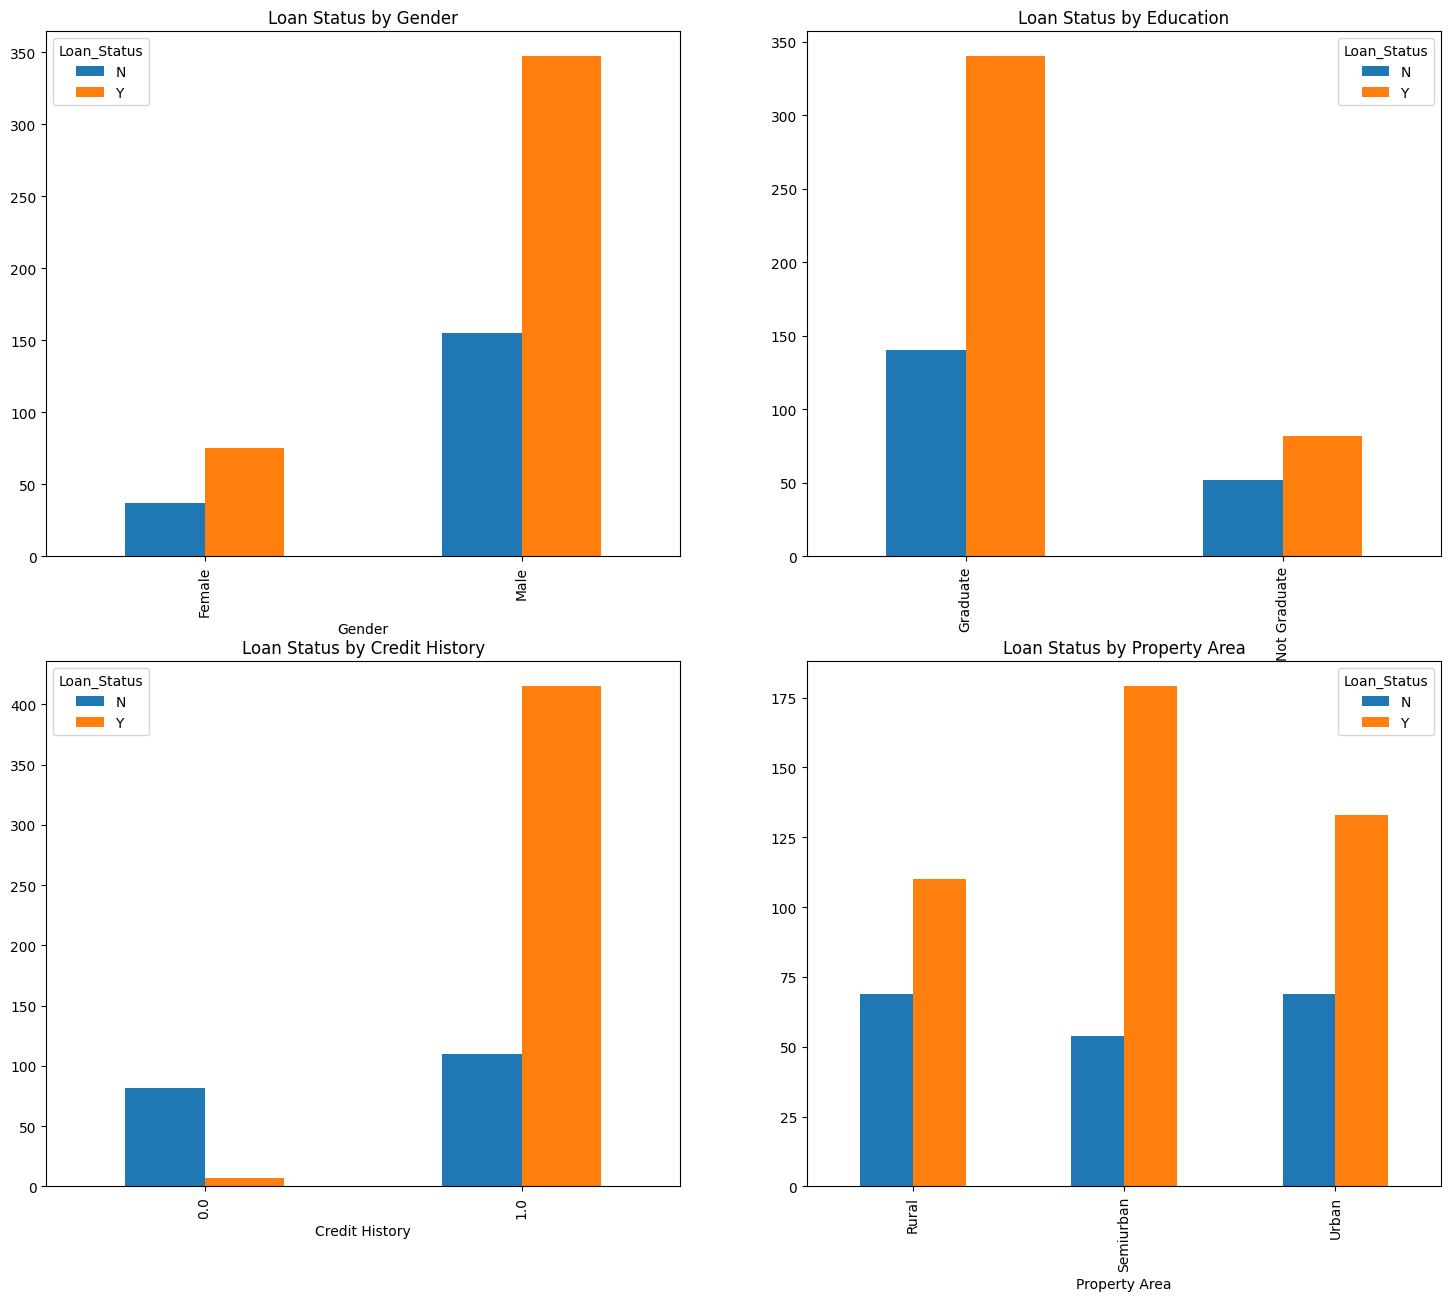

In [8]:
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(18, 15))

# Gender vs Loan Status
pd.crosstab(df_new['Gender'], df_new['Loan_Status']).plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Loan Status by Gender')
axes[0,0].set_xlabel('Gender')

# Education vs Loan Status
pd.crosstab(df_new['Education'], df_new['Loan_Status']).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Loan Status by Education')
axes[0,1].set_xlabel('Education')

# Credit History vs Loan Status
pd.crosstab(df_new['Credit_History'], df_new['Loan_Status']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Loan Status by Credit History')
axes[1,0].set_xlabel('Credit History')

# Property Area vs Loan Status
pd.crosstab(df_new['Property_Area'], df_new['Loan_Status']).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Loan Status by Property Area')
axes[1,1].set_xlabel('Property Area')

Text(0.5, 1.0, 'Correlation Matrix')

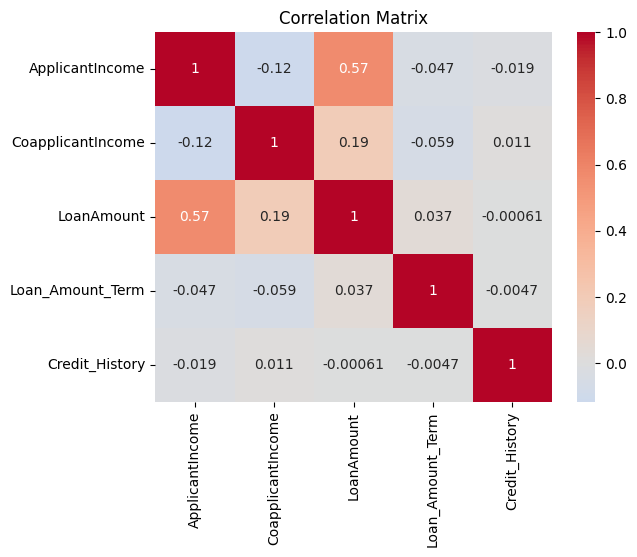

In [9]:
# Correlation heatmap for numerical features
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
corr_matrix = df_new[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

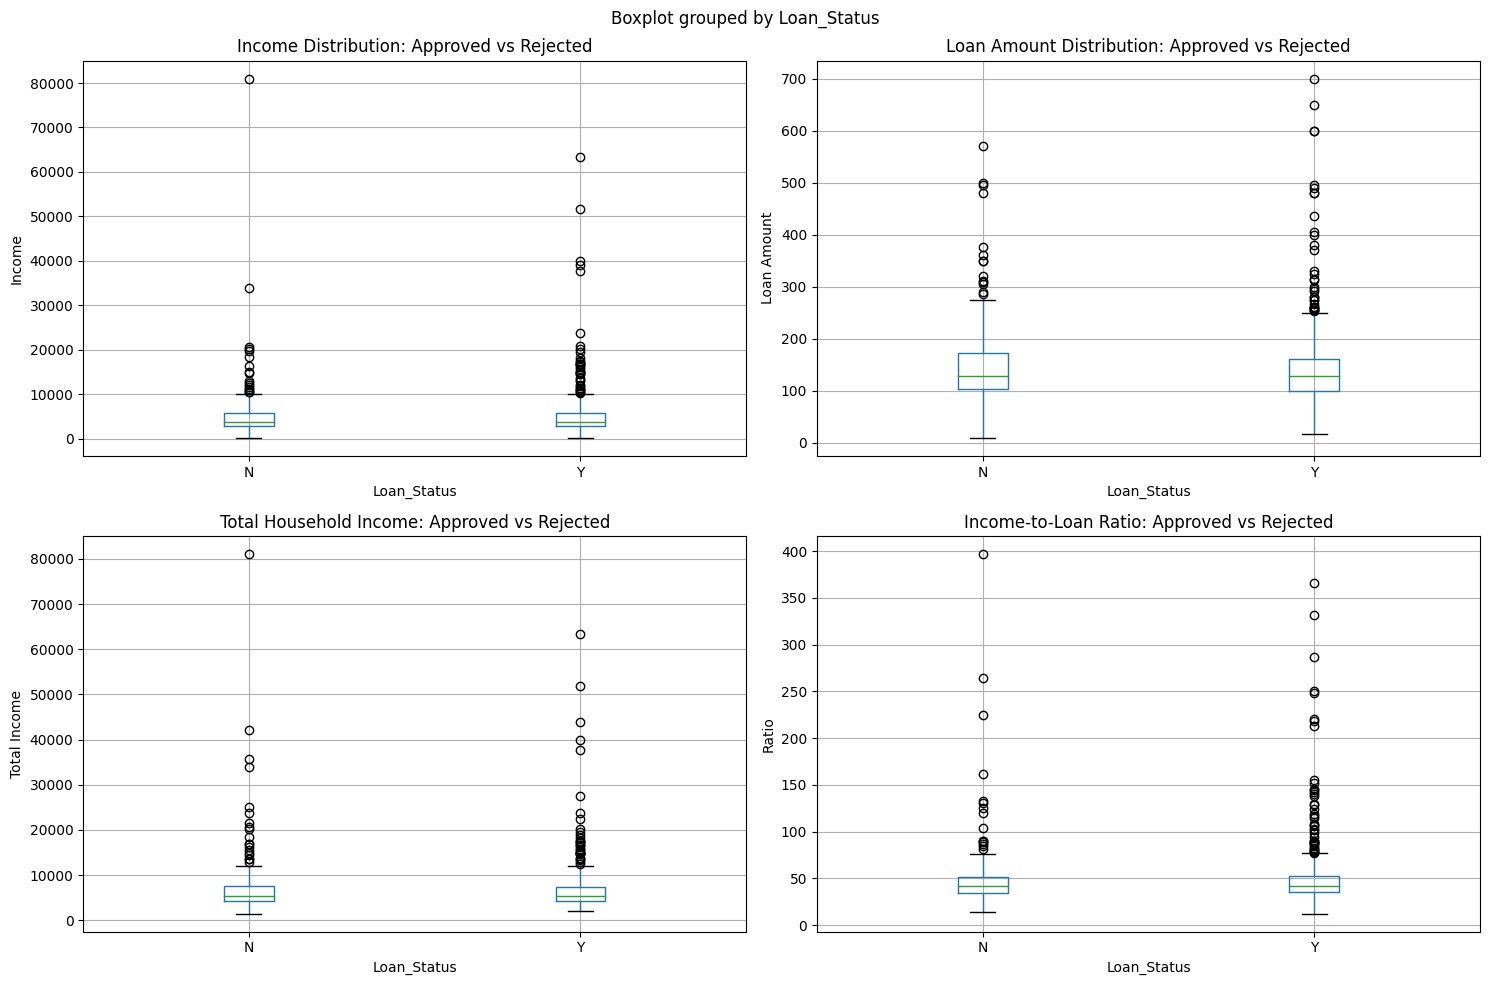

In [10]:
# Box plot analysis
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Income by loan status
df_new.boxplot(column='ApplicantIncome', by='Loan_Status', ax=axes[0,0])
axes[0,0].set_title('Income Distribution: Approved vs Rejected')
axes[0,0].set_ylabel('Income')

# Loan amount by loan status
df_new.boxplot(column='LoanAmount', by='Loan_Status', ax=axes[0,1])
axes[0,1].set_title('Loan Amount Distribution: Approved vs Rejected')
axes[0,1].set_ylabel('Loan Amount')

# Total income
df_new['Total_Income'] = df_new['ApplicantIncome'] + df_new['CoapplicantIncome']
df_new.boxplot(column='Total_Income', by='Loan_Status', ax=axes[1,0])
axes[1,0].set_title('Total Household Income: Approved vs Rejected')
axes[1,0].set_ylabel('Total Income')

# Income to loan ratio
df_new['Income_Loan_Ratio'] = df_new['Total_Income'] / df_new['LoanAmount']
df_new.boxplot(column='Income_Loan_Ratio', by='Loan_Status', ax=axes[1,1])
axes[1,1].set_title('Income-to-Loan Ratio: Approved vs Rejected')
axes[1,1].set_ylabel('Ratio')

plt.tight_layout()
plt.show()


#### Create New Features

In [11]:
# New features
df_new['Total_Income'] = df_new['ApplicantIncome'] + df_new['CoapplicantIncome']
df_new['Loan_per_Term'] = df_new['LoanAmount'] / df_new['Loan_Amount_Term']
df_new['Has_Coapplicant'] = (df_new['CoapplicantIncome'] > 0).astype(int)

# Income categories based on distribution
df_new['Income_Category'] = pd.cut(df_new['Total_Income'], 
                                 bins=[0, 5000, 10000, 20000, float('inf')], 
                                 labels=['Low', 'Medium', 'High', 'Very High'])


#### Handle Outliers

In [12]:
# Remove or cap extreme outliers
Q1 = df_new['ApplicantIncome'].quantile(0.25)
Q3 = df_new['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers instead of removing
df_new['ApplicantIncome'] = df_new['ApplicantIncome'].clip(lower_bound, upper_bound)


#### Data Preprocessing


In [13]:
# One-hot encoding for categorical variables
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 
                       'Self_Employed', 'Property_Area']

df_encoded = pd.get_dummies(df_new, columns=categorical_features, 
                              drop_first=True)

# NOW calculate correlations on the encoded dataset
numerical_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features 
                     if col not in ['Loan_Status', 'Loan_ID']]

In [14]:
# Feature scaling
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

In [15]:
# Correlation analysis
corr_matrix = df_scaled[numerical_features].corr()

# Remove highly correlated features
features_to_remove = []
threshold = 0.8

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            print(f"High correlation: {feature1} <-> {feature2}: {corr_matrix.iloc[i, j]:.3f}")
            
            if feature2 not in features_to_remove:
                features_to_remove.append(feature2)

print(f"\nFeatures to remove due to high correlation: {features_to_remove}")

# Final feature set
final_features = [col for col in numerical_features if col not in features_to_remove]
print(f"\nFinal feature set ({len(final_features)} features):")
for feature in final_features:
    print(f"  {feature}")



Features to remove due to high correlation: []

Final feature set (9 features):
  ApplicantIncome
  CoapplicantIncome
  LoanAmount
  Loan_Amount_Term
  Credit_History
  Total_Income
  Income_Loan_Ratio
  Loan_per_Term
  Has_Coapplicant


In [16]:
df_encoded.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Total_Income,Income_Loan_Ratio,Loan_per_Term,...,Income_Category,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849.0,0.0,128.0,360.0,1.0,Y,5849.0,45.695312,0.355556,...,Medium,True,False,False,False,False,False,False,False,True
1,LP001003,4583.0,1508.0,128.0,360.0,1.0,N,6091.0,47.585938,0.355556,...,Medium,True,True,True,False,False,False,False,False,False
2,LP001005,3000.0,0.0,66.0,360.0,1.0,Y,3000.0,45.454545,0.183333,...,Low,True,True,False,False,False,False,True,False,True
3,LP001006,2583.0,2358.0,120.0,360.0,1.0,Y,4941.0,41.175000,0.333333,...,Low,True,True,False,False,False,True,False,False,True
4,LP001008,6000.0,0.0,141.0,360.0,1.0,Y,6000.0,42.553191,0.391667,...,Medium,True,False,False,False,False,False,False,False,True


In [17]:
df_scaled.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Total_Income,Income_Loan_Ratio,Loan_per_Term,...,Income_Category,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0.497164,-0.554487,-0.211241,0.273231,0.411733,Y,-0.182184,-0.145811,-0.231305,...,Medium,True,False,False,False,False,False,False,False,True
1,LP001003,-0.013767,-0.038732,-0.211241,0.273231,0.411733,N,-0.144684,-0.095634,-0.231305,...,Medium,True,True,True,False,False,False,False,False,False
2,LP001005,-0.652632,-0.554487,-0.948996,0.273231,0.411733,Y,-0.623656,-0.152201,-0.568521,...,Low,True,True,False,False,False,False,True,False,True
3,LP001006,-0.820924,0.251980,-0.306435,0.273231,0.411733,Y,-0.322885,-0.265781,-0.274817,...,Low,True,True,False,False,False,True,False,False,True
4,LP001008,0.558104,-0.554487,-0.056551,0.273231,0.411733,Y,-0.158785,-0.229204,-0.160598,...,Medium,True,False,False,False,False,False,False,False,True


In [18]:
# final features (from correlation analysis)
final_numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                  'Loan_Amount_Term', 'Credit_History', 'Total_Income',
                  'Income_Loan_Ratio', 'Loan_per_Term', 'Has_Coapplicant']

# Get categorical features
categorical_encoded = [col for col in df_encoded.columns 
                      if any(cat in col for cat in ['Gender_', 'Married_', 'Dependents_', 
                                                    'Education_', 'Self_Employed_', 'Property_Area_'])]

all_features = final_numerical + categorical_encoded

# For tree-based models: used df_encoded (no scaling needed)
X_unscaled = df_encoded[all_features]

# For linear models: use df_scaled
X_scaled = df_scaled[all_features]

# Target variable
y = df_encoded['Loan_Status'].map({'Y': 1, 'N': 0})

print(f"Dataset shape: {X_unscaled.shape}")
print(f"Features: {len(all_features)}")

Dataset shape: (614, 18)
Features: 18


In [19]:
# Train-test split for both datasets

#scaled dataset for tree-based models
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
    X_unscaled, y, test_size=0.2, random_state=42, stratify=y
)

# scaled dataset for linear models
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
# Define models with appropriate datasets
models = {
    'Random Forest': {
        'model': RandomForestClassifier(n_estimators=100, random_state=42),
        'X_train': X_train_unscaled,
        'X_test': X_test_unscaled,
        'needs_scaling': False
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'X_train': X_train_unscaled,
        'X_test': X_test_unscaled,
        'needs_scaling': False
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'needs_scaling': True
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'needs_scaling': True
    }
}


In [21]:
# Train and evaluate models
results = {}
for name, config in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name} ({'with scaling' if config['needs_scaling'] else 'without scaling'})")
    print('='*50)
    
    model = config['model']
    X_train = config['X_train']
    X_test = config['X_test']
    
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Rejected', 'Approved']))
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred
    }


Training Random Forest (without scaling)
Accuracy: 0.8862
AUC Score: 0.8663

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.85      0.76      0.81        38
    Approved       0.90      0.94      0.92        85

    accuracy                           0.89       123
   macro avg       0.88      0.85      0.86       123
weighted avg       0.88      0.89      0.88       123


Training Gradient Boosting (without scaling)
Accuracy: 0.8374
AUC Score: 0.8311

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.80      0.63      0.71        38
    Approved       0.85      0.93      0.89        85

    accuracy                           0.84       123
   macro avg       0.82      0.78      0.80       123
weighted avg       0.83      0.84      0.83       123


Training Logistic Regression (with scaling)
Accuracy: 0.8618
AUC Score: 0.8551

Classification Report:
              precision    recall  f

In [22]:
# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\n Best Model: {best_model_name}")
print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Best AUC: {results[best_model_name]['auc']:.4f}")


 Best Model: Random Forest
Best Accuracy: 0.8862
Best AUC: 0.8663



Top 5 Most Important Features:
             feature  importance
4     Credit_History    0.217992
6  Income_Loan_Ratio    0.119204
5       Total_Income    0.119174
0    ApplicantIncome    0.102336
7      Loan_per_Term    0.100090


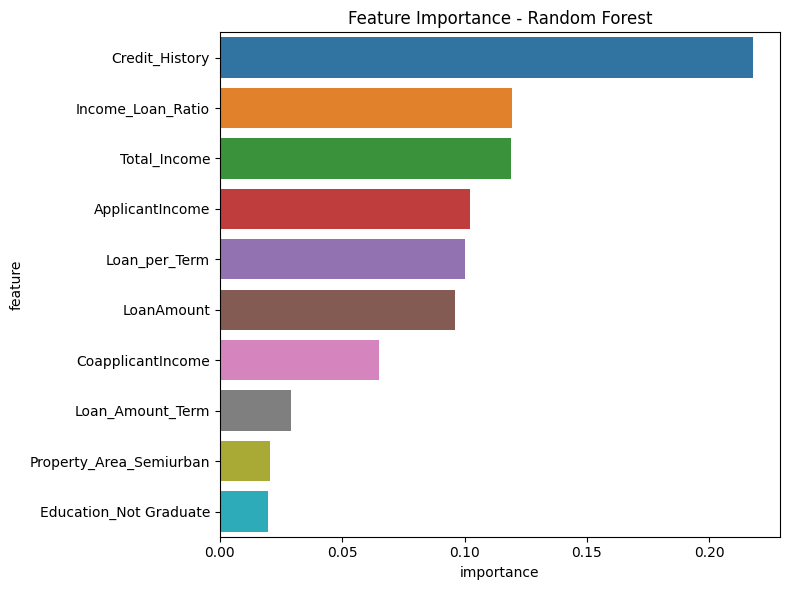

In [23]:
# Feature importance for tree-based models
if best_model_name in ['Random Forest']:
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head(5))
    
    # Visualize
    plt.figure(figsize=(8, 6))
    sns.barplot(data=feature_importance.head(10), y='feature', x='importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()


### Result: 

    Random Forest modelachieved 88.62% accuracy and 86.63% AUC - these are strong performance metrics for loan prediction.
    
    Accuracy: 88.62% - Very good classification performance
    
    AUC: 86.63% - Strong ability to distinguish between approved/rejected loans
    
    Random Forest outperformed other algorithms

Next Steps for Model Improvement:
 Cross-Validation.
 Hyperparameter Tuning

In [24]:
# Analyze prediction errors
cm = confusion_matrix(y_test, results['Random Forest']['predictions'])
print("Confusion Matrix:")
print(cm)

# Business metrics
false_positives = cm[0, 1]  # Approved bad loans (costly!)
false_negatives = cm[1, 0]  # Rejected good customers (lost business)

print(f"False Positives (Bad loans approved): {false_positives}")
print(f"False Negatives (Good customers rejected): {false_negatives}")


Confusion Matrix:
[[29  9]
 [ 5 80]]
False Positives (Bad loans approved): 9
False Negatives (Good customers rejected): 5


In [25]:
# Cross-Validation
cv_scores = cross_val_score(best_model, X_train_unscaled, y_train, 
                           cv=5, scoring='accuracy')
cv_auc = cross_val_score(best_model, X_train_unscaled, y_train, 
                        cv=5, scoring='roc_auc')

print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Cross-validation AUC: {cv_auc.mean():.4f} (+/- {cv_auc.std() * 2:.4f})")


Cross-validation Accuracy: 0.7719 (+/- 0.0495)
Cross-validation AUC: 0.7465 (+/- 0.0880)


#### Cross-Validation Results:

    CV Accuracy: 77.19% (±4.95%)
    CV AUC: 74.65% (±8.80%)

The ~11% difference suggests potential overfitting or data leakage.

In [26]:
#Hyperparameter Tuning

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_unscaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best CV score: 0.7983714698000413


#### hyperparameter tuning increased performance from 77.19% to 79.84% CV accuracy

In [27]:
# Train final model with best parameters
final_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42
)

# Final evaluation
final_model.fit(X_train_unscaled, y_train)
final_predictions = final_model.predict(X_test_unscaled)
final_probabilities = final_model.predict_proba(X_test_unscaled)[:, 1]

final_accuracy = accuracy_score(y_test, final_predictions)
final_auc = roc_auc_score(y_test, final_probabilities)

print(f"Final Model Performance:")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Test AUC: {final_auc:.4f}")
print(f"CV Accuracy: 79.84%")

print("\nFinal Classification Report:")
print(classification_report(y_test, final_predictions, target_names=['Rejected', 'Approved']))


Final Model Performance:
Test Accuracy: 0.8780
Test AUC: 0.8666
CV Accuracy: 79.84%

Final Classification Report:
              precision    recall  f1-score   support

    Rejected       0.90      0.68      0.78        38
    Approved       0.87      0.96      0.92        85

    accuracy                           0.88       123
   macro avg       0.88      0.82      0.85       123
weighted avg       0.88      0.88      0.87       123



Strong loan prediction model with 79.84% CV accuracy - excellent at approving good customers (96% recall) but misses some risky loans (68% recall for rejections).